# Traffic Accident Time Series Forecasting using LSTM & GRU

## Import Libraries and Dependencies

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
import warnings
warnings.filterwarnings('ignore')

2025-05-19 14:24:15.123155: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747664655.318322      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747664655.372786      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Define Dataset Paths and Configuration

In [2]:
# Define file paths and the dataset name
file_path = "/kaggle/input/thailand-fatal-road-accident/thailand_fatal_raod_accident_2011_2022.csv"  # Change for each dataset
output_file = "processed_thailand_fatal_raod_accident_2011_2022.csv"  # Output file for preprocessed data
dataset_name = "thailand_fatal_raod_accident_2011_2022"  # Change for each dataset

In [3]:
# Load CSV file
data = pd.read_csv(file_path)
print("Dataset loaded successfully!")

Dataset loaded successfully!


In [4]:
# Display dataset structure and data types
print(f"--- Information for Data Set: ")
print(data.info()) 
print("\nOverview of the first 5 rows:\n")
try:
    from IPython.display import display
    display(data.head(5))  # Use display in Jupyter environments
except ImportError:
    print(data.head(5))  # Fallback to print in non-Jupyter environments

--- Information for Data Set: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240924 entries, 0 to 240923
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   accident_date        106950 non-null  object 
 1   official_death_date  240924 non-null  object 
 2   age                  211110 non-null  float64
 3   gender               240924 non-null  object 
 4   nationality          240924 non-null  object 
 5   accident_cause_code  240924 non-null  object 
 6   accident_cause       240924 non-null  object 
 7   vehicle_type         240924 non-null  object 
 8   province_th          240924 non-null  object 
 9   district_th          240924 non-null  object 
 10  sub_district_th      240924 non-null  object 
 11  province_en          240924 non-null  object 
 12  district_en          240924 non-null  object 
 13  sub_district_en      240924 non-null  object 
 14  latitude             240924 non-null 

,accident_date,official_death_date,age,gender,nationality,accident_cause_code,accident_cause,vehicle_type,province_th,district_th,sub_district_th,province_en,district_en,sub_district_en,latitude,longitude
0,2011-01-01 00:25:00,2011-01-01,21.0,Male,Thai,V892,Person injured in unspecified motor-vehicle ac...,unidentified,เพชรบูรณ์,บึงสามพัน,บึงสามพัน,Phetchabun,Bueng Sam Phan,Bueng Sam Phan,15.794114,101.006878
1,2011-01-01 06:35:00,2011-01-01,23.0,Male,Thai,V299,Motorcycle rider [any] injured in unspecified ...,moterbike,สุราษฎร์ธานี,พนม,พังกาญจน์,Surat Thani,Phanom,Phangkan,8.916207,98.890434
2,2011-01-01 19:00:00,2011-01-01,26.0,Male,Thai,V234,Motorcycle rider injured in collision with car...,moterbike,ระยอง,บ้านฉาง,บ้านฉาง,Rayong,Ban Chang,Ban Chang,12.734329,101.065845
3,2011-01-01 02:00:00,2011-01-01,16.0,Male,Thai,V429,Car occupant injured in collision with two-or ...,car,พิษณุโลก,บางระกำ,ปลักแรด,Phitsanulok,Bang Rakam,Plak Rad,16.662980,100.120976
4,2011-01-01 02:00:00,2011-01-01,12.0,Male,Thai,V429,Car occupant injured in collision with two-or ...,car,พิษณุโลก,บางระกำ,ปลักแรด,Phitsanulok,Bang Rakam,Plak Rad,16.662980,100.120976


In [5]:
# Standardize Date column
print(f"--- Date Standardization for {dataset_name} ---")
print(f"Rows before standardization: {len(data)}")
def parse_date(date_str):
    try:
        return pd.to_datetime(date_str, format='%d/%m/%Y')  # For format like 4/01/2005
    except:
        return pd.to_datetime(date_str)  # For format like 2016-02-08 05:46:00

data['accident_date'] = data['accident_date'].apply(parse_date)
data['accident_date'] = data['accident_date'].dt.strftime('%Y-%m-%d')  # Unify format
data['accident_date'] = pd.to_datetime(data['accident_date'])
print(f"Rows after standardization: {len(data)}")
print("Date format unified to YYYY-MM-DD")

--- Date Standardization for thailand_fatal_raod_accident_2011_2022 ---
Rows before standardization: 240924
Rows after standardization: 240924
Date format unified to YYYY-MM-DD


In [6]:
# Ensure 'Date' column is in datetime format
data['accident_date'] = pd.to_datetime(data['accident_date'])

# Calculate monthly incident counts
daily_incidents = data.groupby(data['accident_date'].dt.to_period('D')).size().reset_index(name='incident_count')
daily_incidents['accident_date'] = daily_incidents['accident_date'].dt.to_timestamp()  # تحويل إلى Timestamp
daily_incidents.set_index('accident_date', inplace=True)

# Print the result
print(daily_incidents)

               incident_count
accident_date                
2010-01-03                  2
2010-01-06                  2
2010-01-18                  1
2010-01-19                  1
2010-01-22                  1
...                       ...
2021-12-27                 21
2021-12-28                 32
2021-12-29                 29
2021-12-30                 36
2021-12-31                 61

[4124 rows x 1 columns]


In [7]:
# Create daily time series, then resample to monthly and sum, filling missing values with 0
time_series = daily_incidents['incident_count'].resample('D').sum().fillna(0)

# Print the result
print(time_series)

accident_date
2010-01-03     2
2010-01-04     0
2010-01-05     0
2010-01-06     2
2010-01-07     0
              ..
2021-12-27    21
2021-12-28    32
2021-12-29    29
2021-12-30    36
2021-12-31    61
Freq: D, Name: incident_count, Length: 4381, dtype: int64


In [8]:
# Save preprocessed data to CSV
processed_data = pd.DataFrame({
    'date': time_series.index,
    'incident_count': time_series.values
})
processed_data.to_csv(output_file, index=False)
print(f"--- Preprocessed Data Saved for {dataset_name} ---")
print(f"File saved at: {output_file}")

--- Preprocessed Data Saved for thailand_fatal_raod_accident_2011_2022 ---
File saved at: processed_thailand_fatal_raod_accident_2011_2022.csv


In [9]:
def test_stationarity(timeseries):
    result = adfuller(timeseries.dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    for key, value in result[4].items():
        print(f'Critical Value ({key}): {value:.3f}')
    return result[1]

In [10]:
# Test stationarity
p_value = test_stationarity(time_series)
print(f"--- Stationarity Test Result for {dataset_name} ---")
print(f"ADF p-value: {p_value}")

ADF Statistic: -3.408004
p-value: 0.010689
Critical Value (1%): -3.432
Critical Value (5%): -2.862
Critical Value (10%): -2.567
--- Stationarity Test Result for thailand_fatal_raod_accident_2011_2022 ---
ADF p-value: 0.010689011601876653


In [11]:
# Function to decompose time series into components
def decompose_series(timeseries, dataset_name):
    decomposition = seasonal_decompose(timeseries, model='additive', period=30)  # Assume monthly seasonality
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    # Plot components with titles
    plt.figure(figsize=(12, 8))
    plt.subplot(411)
    plt.plot(timeseries, label='Original Series')
    plt.legend(loc='best')
    plt.title(f'Original Time Series - {dataset_name}')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.title(f'Trend Component - {dataset_name}')
    plt.subplot(413)
    plt.plot(seasonal, label='Seasonality')
    plt.legend(loc='best')
    plt.title(f'Seasonal Component - {dataset_name}')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.title(f'Residual Component - {dataset_name}')
    plt.suptitle(f'Time Series Decomposition - {dataset_name}')
    plt.tight_layout()
    plt.show()

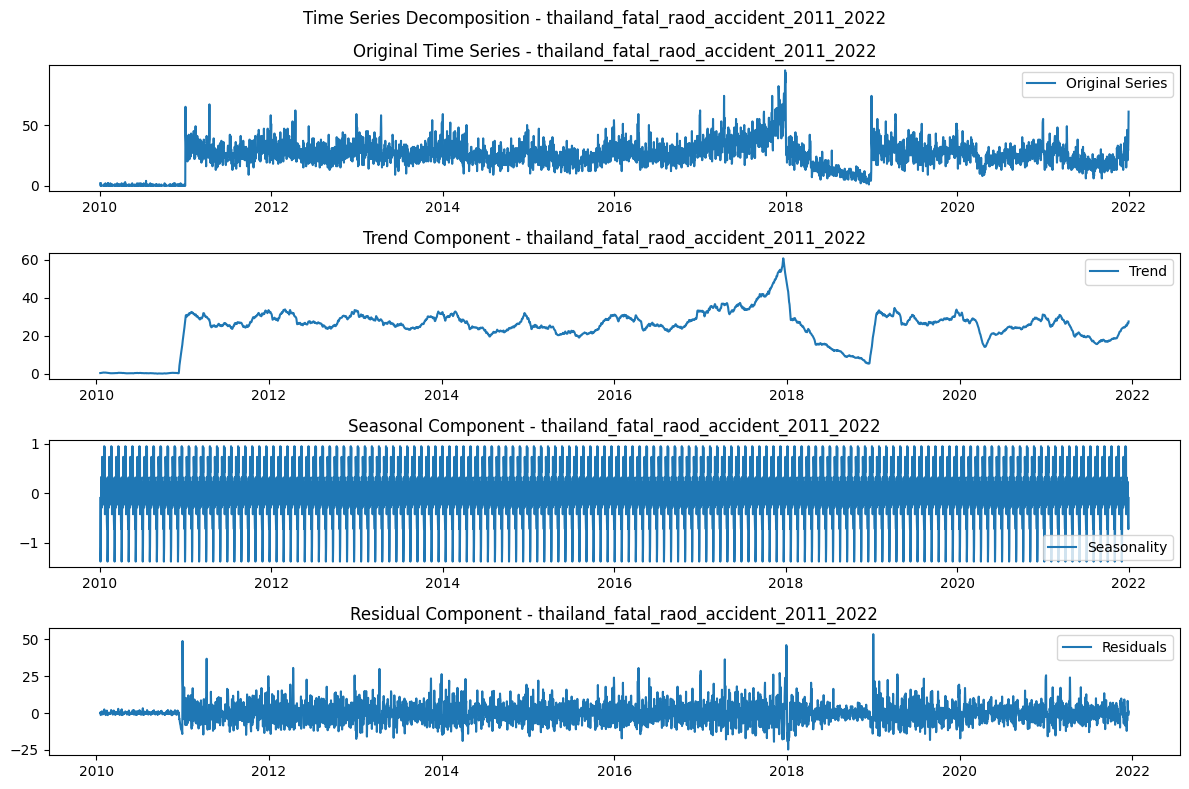

In [12]:
# Decompose time series
decompose_series(time_series, dataset_name)

In [13]:
# Function to analyze daily and monthly patterns
def analyze_day_month_patterns(dataframe, dataset_name):
    # Extract day and month
    dataframe['day'] = dataframe['accident_date'].dt.day
    dataframe['month'] = dataframe['accident_date'].dt.month
    
    # Plot incidents by day
    day_counts = dataframe.groupby('day').size()
    plt.figure(figsize=(10, 5))
    day_counts.plot(kind='bar')
    plt.title(f'Incident Count by Day of Month - {dataset_name}')
    plt.xlabel('Day of Month')
    plt.ylabel('Incident Count')
    plt.show()
    
    # Plot incidents by month
    month_counts = dataframe.groupby('month').size()
    plt.figure(figsize=(10, 5))
    month_counts.plot(kind='bar')
    plt.title(f'Incident Count by Month - {dataset_name}')
    plt.xlabel('Month')
    plt.ylabel('Incident Count')
    plt.show()

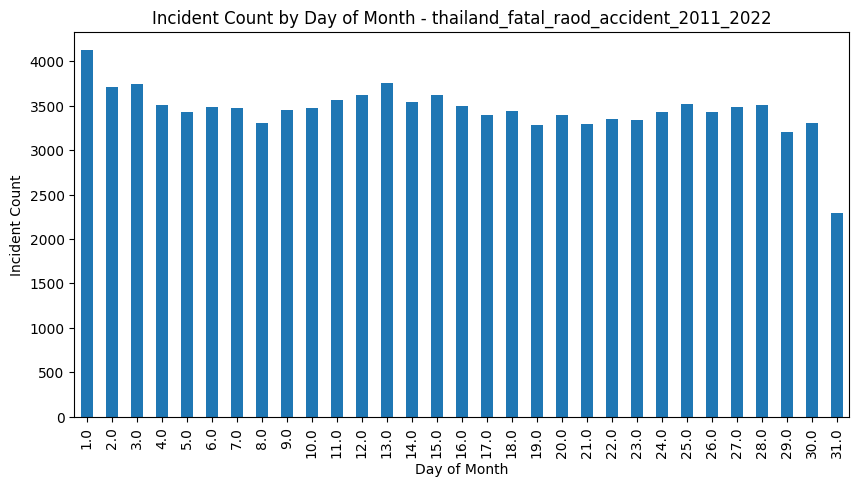

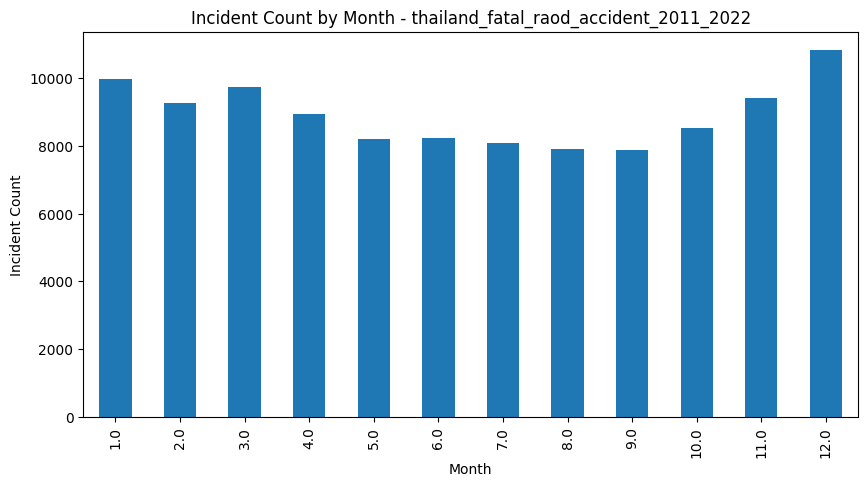

In [14]:
# Analyze day and month patterns
analyze_day_month_patterns(data, dataset_name)

# Preprocessing

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Normalize data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(time_series.values.reshape(-1, 1))

# Print normalized data
print("--- Scaled Data (First 10 values) ---")
print(scaled_data[:10])

--- Scaled Data (First 10 values) ---
[[0.02105263]
 [0.        ]
 [0.        ]
 [0.02105263]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]]


In [16]:
print("Original min:", time_series.min(), "max:", time_series.max())
print("Scaled min:", scaled_data.min(), "max:", scaled_data.max())

Original min: 0 max: 95
Scaled min: 0.0 max: 1.0


In [17]:
# Create sequences
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

In [18]:
window_size = 30  # 1 months 
X, y = create_sequences(scaled_data, window_size)

print(f"--- Sequence Creation ---")
print(f"Input shape (X): {X.shape}")  # (samples, timesteps, features)
print(f"Target shape (y): {y.shape}")
print(f"Example input sequence (first sample):\n{X[0].flatten()}")
print(f"Corresponding target value: {y[0]}")

# Reshape for RNN input: [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

print(f"\n--- Train-Test Split ---")
print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")
print(f"Input sequence shape: {X_train.shape[1]} timesteps x {X_train.shape[2]} feature(s)")


--- Sequence Creation ---
Input shape (X): (4351, 30)
Target shape (y): (4351,)
Example input sequence (first sample):
[0.02105263 0.         0.         0.02105263 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.01052632 0.01052632 0.
 0.         0.01052632 0.         0.         0.02105263 0.
 0.01052632 0.01052632 0.         0.         0.01052632 0.01052632]
Corresponding target value: 0.010526315789473684

--- Train-Test Split ---
Training samples: 3480
Testing samples: 871
Input sequence shape: 30 timesteps x 1 feature(s)


# Step 2: LSTM Model (0, 2, 4 hidden layers)

In [19]:
import pandas as pd
import numpy as np
import time  # To measure training time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error

# Store evaluation results
results = []

# Define hidden layer configurations
hidden_layer_configs = [0, 2, 4]

# Store predictions for each configuration
lstm_predictions = {
    0: [],
    2: [],
    4: []
}

for num_hidden_layers in hidden_layer_configs:
    print(f"\n Training LSTM with {num_hidden_layers} hidden layers")

    model = Sequential()

    if num_hidden_layers == 0:
       model.add(LSTM(128, input_shape=(X_train.shape[1], 1), activation='tanh'))

    else:
        model.add(LSTM(128, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], 1)))
        for i in range(num_hidden_layers - 1):
            return_seq = (i != num_hidden_layers - 2)
            model.add(LSTM(128, activation='tanh', return_sequences=return_seq))
            # Adding Dropout layer
            model.add(Dropout(0.2))

    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Start timing
    start_time = time.time()

    model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1,
              verbose=1, callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])

    # End timing
    end_time = time.time()
    training_time = end_time - start_time

    # Prediction
    y_pred = model.predict(X_test)
    y_pred_inv = scaler.inverse_transform(y_pred)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Clip negative predictions for MSLE
    y_pred_inv_clipped = np.clip(y_pred_inv, a_min=0, a_max=None)
    y_test_inv_clipped = np.clip(y_test_inv, a_min=0, a_max=None)

    # Save predictions for the current configuration
    lstm_predictions[num_hidden_layers] = y_pred_inv_clipped.flatten()

    # Evaluation
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    r2 = r2_score(y_test_inv, y_pred_inv)
    msle = mean_squared_log_error(y_test_inv_clipped, y_pred_inv_clipped)

    # Store results
    results.append({
        'Hidden Layers': num_hidden_layers,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MSLE': msle,
        'R2': r2,
        'Training Time (s)': training_time
    })

    print(f" Evaluation (Hidden Layers = {num_hidden_layers}):")
    print(f"MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}, MSLE: {msle:.4f}, R²: {r2:.2f}")
    print(f" Training Time: {training_time:.2f} seconds")


 Training LSTM with 0 hidden layers


I0000 00:00:1747664722.889370      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Epoch 1/100


I0000 00:00:1747664726.167926      62 cuda_dnn.cc:529] Loaded cuDNN version 90300


98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0171 - val_loss: 0.0080
Epoch 2/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0066 - val_loss: 0.0075
Epoch 3/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0059 - val_loss: 0.0073
Epoch 4/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0056 - val_loss: 0.0072
Epoch 5/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0056 - val_loss: 0.0071
Epoch 6/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0055 - val_loss: 0.0070
Epoch 7/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0055 - val_loss: 0.0070
Epoch 8/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0059 - val_loss: 0.0069
Epoch 9/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0055 - val_loss: 0.0069
Epoch 10/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 - val_loss: 0.0070
Epoch 11/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0055 - val_loss: 0.0069
Epoch 12/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0055 - val_l

In [20]:
results_df = pd.DataFrame(results)
print("\n Summary of LSTM Results with Varying Hidden Layers:\n")
print(results_df)


 Summary of LSTM Results with Varying Hidden Layers:

   Hidden Layers        MSE      RMSE       MAE      MSLE        R2  \
0              0  35.515601  5.959497  4.658083  0.060983  0.384787   
1              2  35.424775  5.951872  4.634000  0.060153  0.386360   
2              4  35.899898  5.991652  4.619516  0.059039  0.378130   

   Training Time (s)  
0          11.208031  
1          19.194682  
2          32.350956  


In [21]:
# Now, create a DataFrame for LSTM results and predictions
lstm_results_df = pd.DataFrame({
    'Day': time_series.index[-len(y_test):].strftime('%Y-%m-%d'),
    'Original': y_test_inv.flatten(),
    'Predicted_LSTM_0_Layers': lstm_predictions[0],
    'Predicted_LSTM_2_Layers': lstm_predictions[2],
    'Predicted_LSTM_4_Layers': lstm_predictions[4]
})

# Display first 12 rows of LSTM results
print("\nLSTM Results:")
print(lstm_results_df.head(5))


LSTM Results:
          Day  Original  Predicted_LSTM_0_Layers  Predicted_LSTM_2_Layers  \
0  2019-08-14      22.0                28.174559                27.641983   
1  2019-08-15      20.0                25.542452                25.257065   
2  2019-08-16      35.0                24.217525                23.925756   
3  2019-08-17      23.0                29.039043                28.678684   
4  2019-08-18      33.0                26.137444                26.111105   

   Predicted_LSTM_4_Layers  
0                26.658298  
1                24.934950  
2                23.568821  
3                26.976788  
4                25.427900  


# GRU

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error
import numpy as np
import pandas as pd
import time

# Store GRU evaluation results
gru_results = []

# Define hidden layer configurations
hidden_layer_configs = [0, 2, 4]

# Dictionary to store GRU predictions for each configuration
gru_predictions = {
    0: [],
    2: [],
    4: []
}

for num_hidden_layers in hidden_layer_configs:
    print(f"\n Training GRU with {num_hidden_layers} hidden layers")

    model = Sequential()

    if num_hidden_layers == 0:
        model.add(GRU(128, activation='tanh', input_shape=(X_train.shape[1], 1)))
        model.add(Dropout(0.2))
    else:
        model.add(GRU(128, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], 1)))
        model.add(Dropout(0.2))
        for i in range(num_hidden_layers - 1):
            return_seq = (i != num_hidden_layers - 2)
            model.add(GRU(128, activation='tanh', return_sequences=return_seq))
            model.add(Dropout(0.2))

    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Start timing
    start_time = time.time()

    model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1,
              verbose=1, callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])

    # End timing
    end_time = time.time()
    training_time = end_time - start_time

    # Prediction
    y_pred = model.predict(X_test)
    y_pred_inv = scaler.inverse_transform(y_pred)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Clip negative predictions for MSLE
    y_pred_inv_clipped = np.clip(y_pred_inv, a_min=0, a_max=None)
    y_test_inv_clipped = np.clip(y_test_inv, a_min=0, a_max=None)

    # Evaluation
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    r2 = r2_score(y_test_inv, y_pred_inv)
    msle = mean_squared_log_error(y_test_inv_clipped, y_pred_inv_clipped)

    # Store results
    gru_results.append({
        'Hidden Layers': num_hidden_layers,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MSLE': msle,
        'R2': r2,
        'Training Time (s)': training_time
    })

    # Store predictions for each configuration
    gru_predictions[num_hidden_layers] = y_pred_inv_clipped.flatten()

    print(f" Evaluation (GRU Hidden Layers = {num_hidden_layers}):")
    print(f"MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}, MSLE: {msle:.4f}, R²: {r2:.2f}")
    print(f" Training Time: {training_time:.2f} seconds")


 Training GRU with 0 hidden layers
Epoch 1/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0151 - val_loss: 0.0073
Epoch 2/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0065 - val_loss: 0.0071
Epoch 3/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0061 - val_loss: 0.0071
Epoch 4/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0061 - val_loss: 0.0068
Epoch 5/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0058 - val_loss: 0.0071
Epoch 6/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0059 - val_loss: 0.0069
Epoch 7/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0054 - val_loss: 0.0072
Epoch 8/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0056 - val_loss: 0.0073
Epoch 9/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0064 - val_loss: 0.0068
Epoch 10/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 - val_loss: 0.0068
Epoch 11/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 0.0075
Epoch 12/100
98/98 ━━━━━━━━

In [23]:
gru_results_df = pd.DataFrame(gru_results)
print("\n GRU Model Summary:\n")
print(gru_results_df)


 GRU Model Summary:

   Hidden Layers        MSE      RMSE       MAE      MSLE        R2  \
0              0  35.624947  5.968664  4.655721  0.060678  0.382893   
1              2  36.123485  6.010282  4.645035  0.059436  0.374257   
2              4  36.258386  6.021494  4.698895  0.062462  0.371920   

   Training Time (s)  
0           8.081545  
1           9.139174  
2          25.971468  


In [24]:
# Create a DataFrame for GRU predictions
gru_results_df_predictions = pd.DataFrame({
    'Month': time_series.index[-len(y_test):].strftime('%Y-%m'),
    'Original': y_test_inv.flatten(),
    'Predicted_GRU_0_Layers': gru_predictions[0],
    'Predicted_GRU_2_Layers': gru_predictions[2],
    'Predicted_GRU_4_Layers': gru_predictions[4]
})

# Display first 10 rows of GRU predictions
print("\nGRU Predictions:")
print(gru_results_df_predictions.head(5))


GRU Predictions:
     Month  Original  Predicted_GRU_0_Layers  Predicted_GRU_2_Layers  \
0  2019-08      22.0               28.021799               26.746235   
1  2019-08      20.0               25.386950               24.324188   
2  2019-08      35.0               24.128786               23.007046   
3  2019-08      23.0               28.771454               27.598450   
4  2019-08      33.0               25.767395               24.924528   

   Predicted_GRU_4_Layers  
0               27.560415  
1               25.999857  
2               24.739483  
3               28.767229  
4               27.098648  


In [25]:
gru_results_df_predictions['Day'] = time_series.index[-len(y_test):].strftime('%Y-%m-%d')


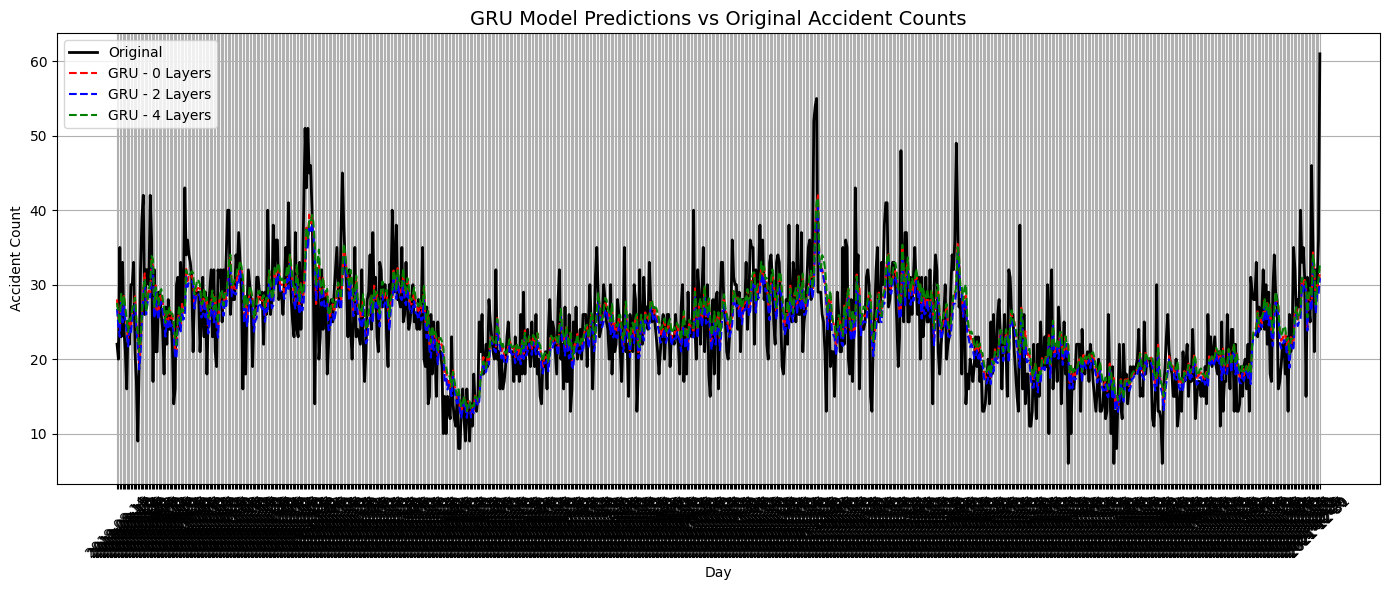

In [26]:
# Plotting all results
plt.figure(figsize=(14, 6))
plt.plot(gru_results_df_predictions['Day'], gru_results_df_predictions['Original'], label='Original', color='black', linewidth=2)
plt.plot(gru_results_df_predictions['Day'], gru_results_df_predictions['Predicted_GRU_0_Layers'], label='GRU - 0 Layers', linestyle='--', color='red')
plt.plot(gru_results_df_predictions['Day'], gru_results_df_predictions['Predicted_GRU_2_Layers'], label='GRU - 2 Layers', linestyle='--', color='blue')
plt.plot(gru_results_df_predictions['Day'], gru_results_df_predictions['Predicted_GRU_4_Layers'], label='GRU - 4 Layers', linestyle='--', color='green')

plt.title('GRU Model Predictions vs Original Accident Counts', fontsize=14)
plt.xlabel('Day')
plt.ylabel('Accident Count')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

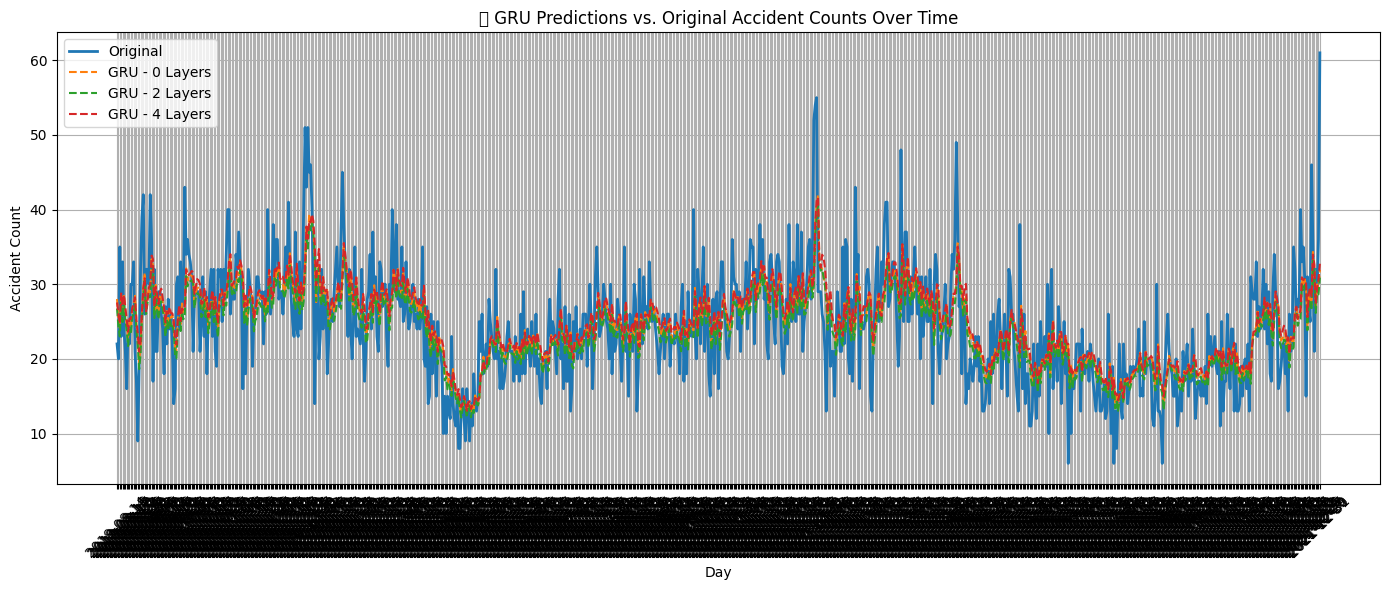

In [27]:
import matplotlib.pyplot as plt

# Set plot size
plt.figure(figsize=(14, 6))

# Plot actual values
plt.plot(gru_results_df_predictions['Day'], gru_results_df_predictions['Original'], label='Original', linewidth=2)

# Plot GRU predictions for each model
plt.plot(gru_results_df_predictions['Day'], gru_results_df_predictions['Predicted_GRU_0_Layers'], label='GRU - 0 Layers', linestyle='--')
plt.plot(gru_results_df_predictions['Day'], gru_results_df_predictions['Predicted_GRU_2_Layers'], label='GRU - 2 Layers', linestyle='--')
plt.plot(gru_results_df_predictions['Day'], gru_results_df_predictions['Predicted_GRU_4_Layers'], label='GRU - 4 Layers', linestyle='--')

# Plot styling
plt.title('📈 GRU Predictions vs. Original Accident Counts Over Time')
plt.xlabel('Day')
plt.ylabel('Accident Count')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()


Training GRU with 0 hidden layers...
Epoch 1/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0261 - val_loss: 0.0074
Epoch 2/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0060 - val_loss: 0.0073
Epoch 3/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0056 - val_loss: 0.0070
Epoch 4/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0052 - val_loss: 0.0070
Epoch 5/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0055 - val_loss: 0.0070
Epoch 6/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0054 - val_loss: 0.0069
Epoch 7/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0054 - val_loss: 0.0070
Epoch 8/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0054 - val_loss: 0.0072
Epoch 9/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0055 - val_loss: 0.0068
Epoch 10/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0056 - val_loss: 0.0070
Epoch 11/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0053 - val_loss: 0.0068
Epoch 12/100
98/98 ━━━━━━

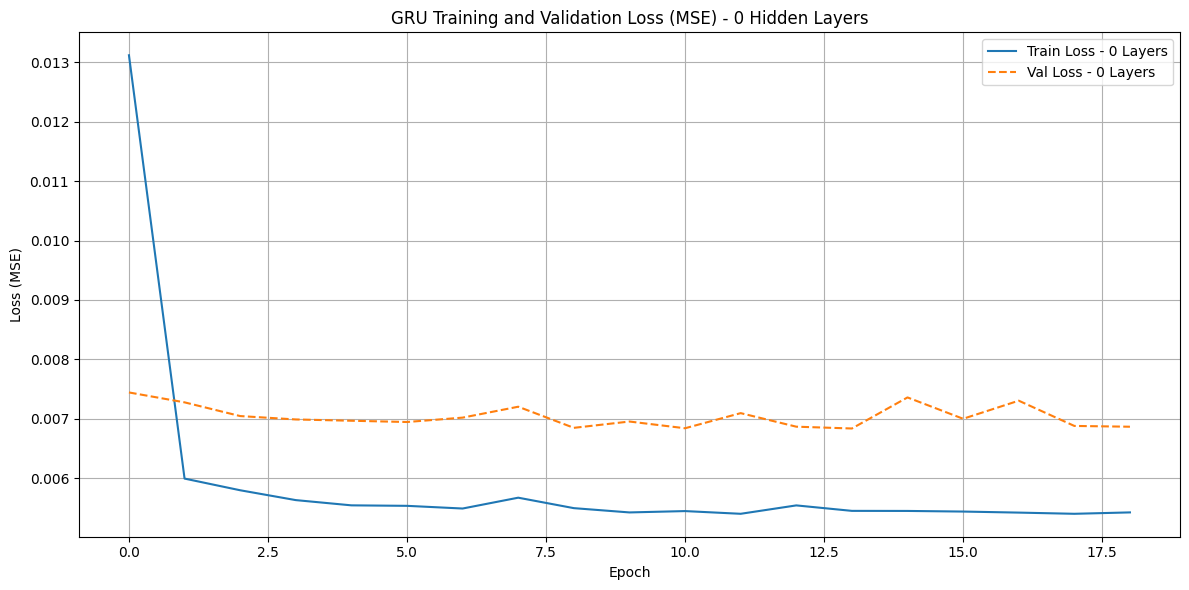

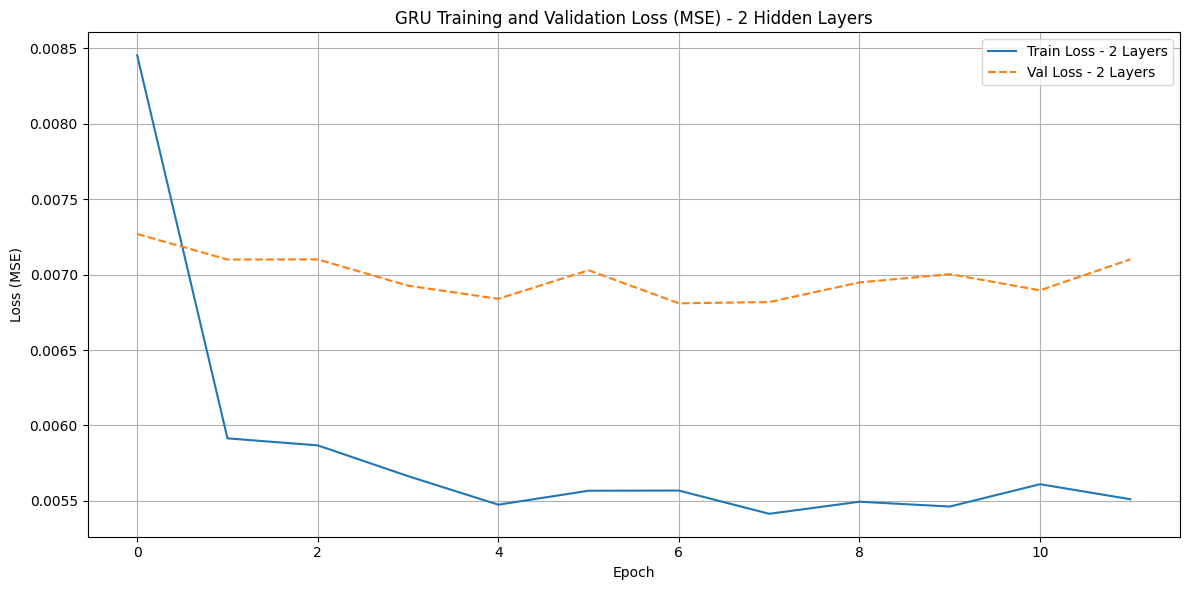

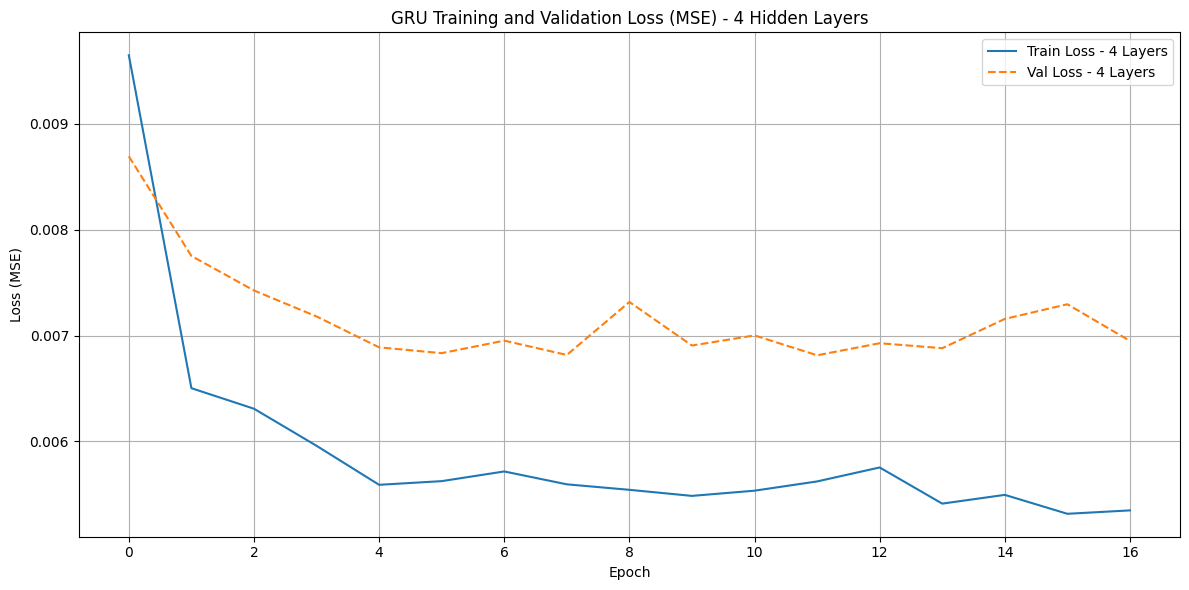

In [28]:
import matplotlib.pyplot as plt

# Initialize dictionary to store training histories
gru_histories = {}

# Define hidden layer configurations
hidden_layer_configs = [0, 2, 4]

for num_hidden_layers in hidden_layer_configs:
    print(f"\nTraining GRU with {num_hidden_layers} hidden layers...")

    # Model definition (same as in your previous code)
    model = Sequential()
    
    if num_hidden_layers == 0:
        model.add(GRU(64, input_shape=(X_train.shape[1], 1)))
    else:
        model.add(GRU(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
        for i in range(num_hidden_layers - 1):
            return_seq = (i != num_hidden_layers - 2)
            model.add(GRU(64, return_sequences=return_seq))

    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Training with EarlyStopping
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1,
                        verbose=1, callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])

    # Store training history for the current model
    gru_histories[num_hidden_layers] = history

# Plotting training and validation loss separately for each model

for num_hidden_layers, history in gru_histories.items():
    plt.figure(figsize=(12, 6))
    
    # Plot Train Loss
    plt.plot(history.history['loss'], label=f'Train Loss - {num_hidden_layers} Layers')
    
    # Plot Validation Loss
    plt.plot(history.history['val_loss'], label=f'Val Loss - {num_hidden_layers} Layers', linestyle='--')

    # Plot formatting for each model
    plt.title(f'GRU Training and Validation Loss (MSE) - {num_hidden_layers} Hidden Layers')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

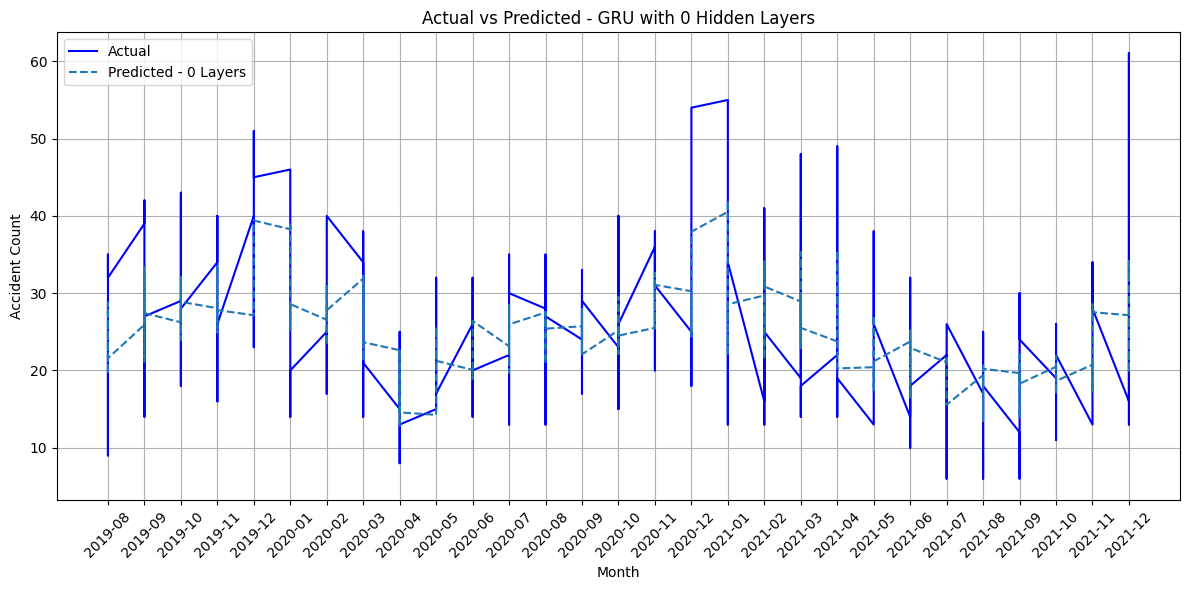

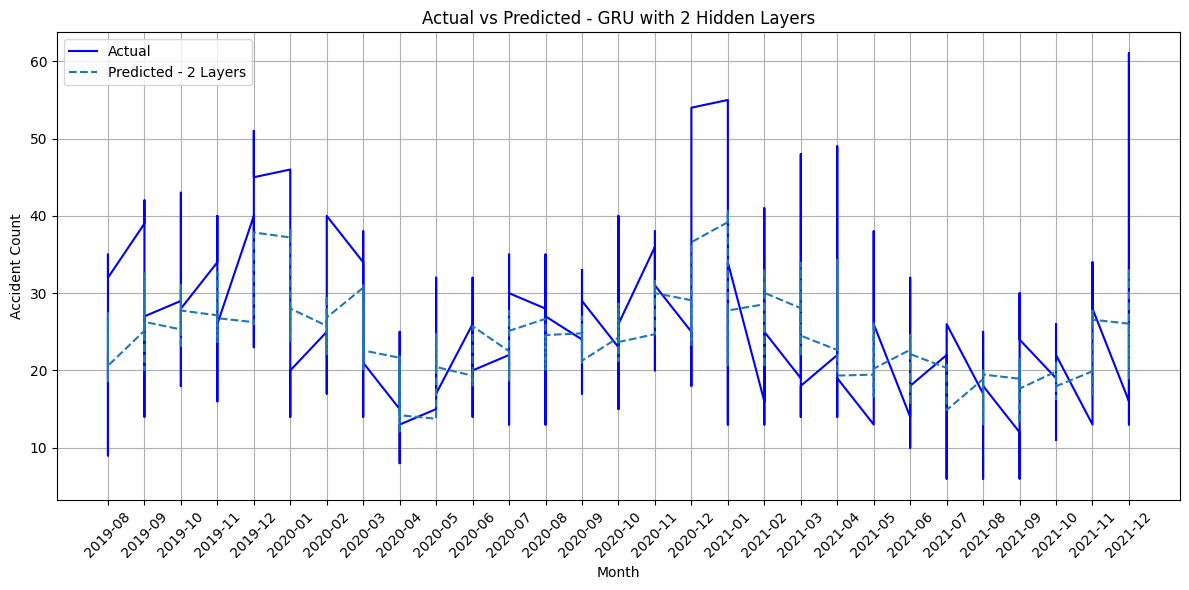

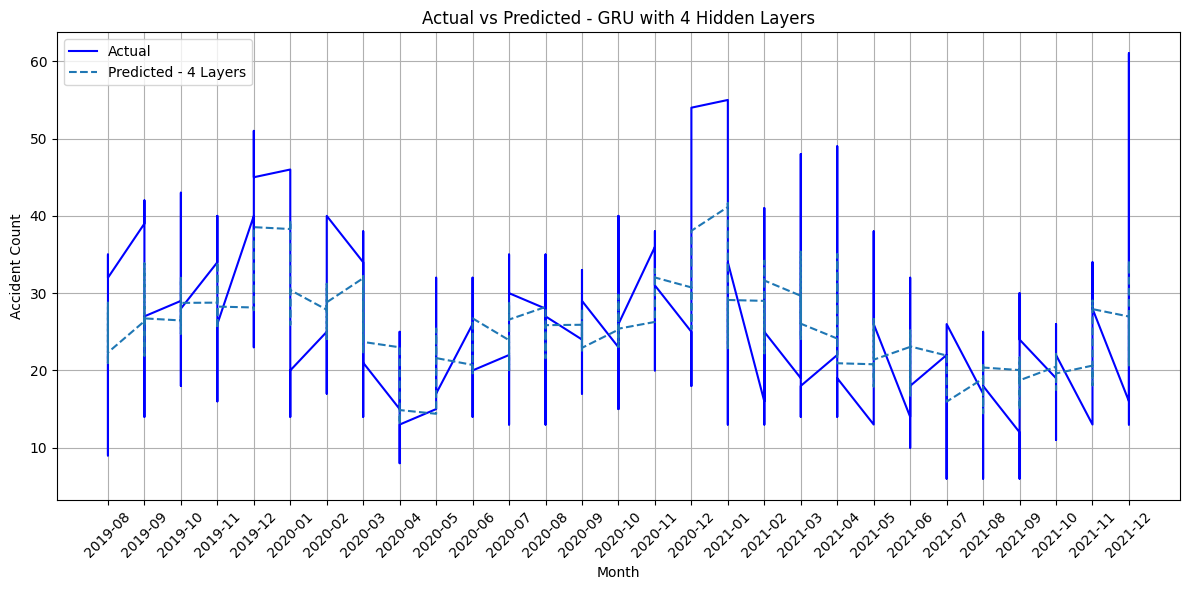

In [29]:
import matplotlib.pyplot as plt

# Create DataFrame for Actual vs Predicted values
gru_results_df_predictions = pd.DataFrame({
    'Month': time_series.index[-len(y_test):].strftime('%Y-%m'),
    'Original': y_test_inv.flatten(),
    'Predicted_GRU_0_Layers': gru_predictions[0],
    'Predicted_GRU_2_Layers': gru_predictions[2],
    'Predicted_GRU_4_Layers': gru_predictions[4]
})

# Plot actual vs predicted values for each configuration

for num_hidden_layers in hidden_layer_configs:
    plt.figure(figsize=(12, 6))

    # Plot actual values
    plt.plot(gru_results_df_predictions['Month'], gru_results_df_predictions['Original'], label='Actual', color='blue')

    # Plot predicted values for the current configuration
    plt.plot(gru_results_df_predictions['Month'], gru_results_df_predictions[f'Predicted_GRU_{num_hidden_layers}_Layers'], label=f'Predicted - {num_hidden_layers} Layers', linestyle='--')

    # Add titles and labels
    plt.title(f'Actual vs Predicted - GRU with {num_hidden_layers} Hidden Layers')
    plt.xlabel('Month')
    plt.ylabel('Accident Count')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()

    # Show plot
    plt.show()

In [30]:
import pandas as pd
import numpy as np

# For a specific configuration, e.g., 2 hidden layers
best_config = 2  # You can change this to 0, 2, or 4

# Flatten true and predicted values for comparison
y_test_flat = y_test_inv.flatten()
y_pred_flat = gru_predictions[best_config]

# Compute absolute errors
errors = np.abs(y_test_flat - y_pred_flat)

# Create a DataFrame for analysis
results_df = pd.DataFrame({
    'True Value': y_test_flat,
    'Predicted Value': y_pred_flat,
    'Absolute Error': errors
})

# Sort by lowest error
best_predictions = results_df.sort_values(by='Absolute Error').head(10)

# Reset index for clarity
best_predictions.reset_index(drop=True, inplace=True)

print("\n📈 Top 10 Best Predictions (Closest to Real Values) for GRU with", best_config, "Hidden Layers:")
print(best_predictions)


📈 Top 10 Best Predictions (Closest to Real Values) for GRU with 2 Hidden Layers:
   True Value  Predicted Value  Absolute Error
0        17.0        16.995249        0.004751
1        23.0        22.980743        0.019257
2        26.0        26.022230        0.022230
3        26.0        26.035707        0.035707
4        23.0        22.960732        0.039268
5        19.0        19.044794        0.044794
6        25.0        24.950176        0.049824
7        20.0        20.051596        0.051596
8        29.0        29.081135        0.081135
9        29.0        28.908243        0.091757


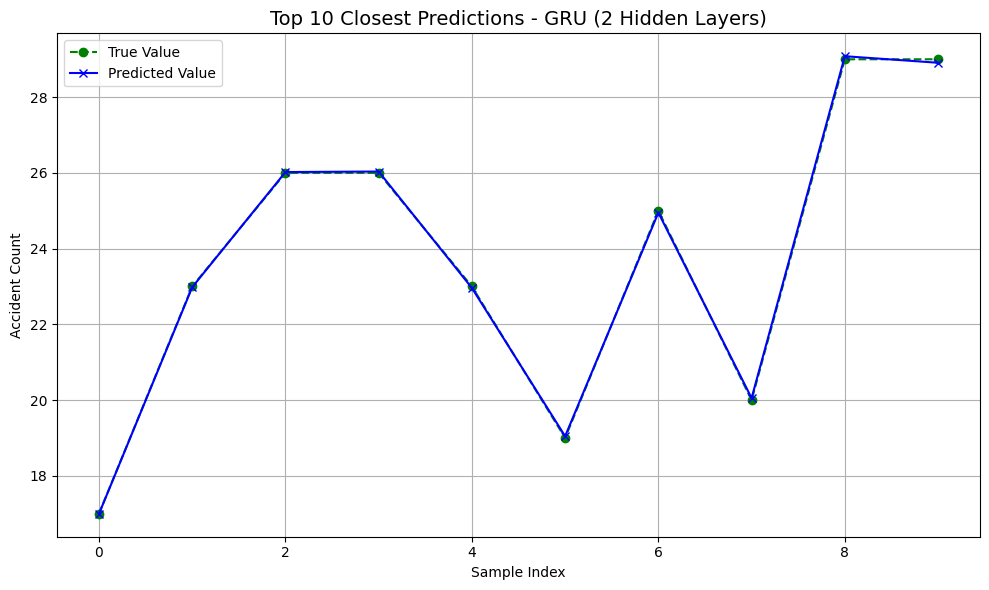

In [31]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(best_predictions['True Value'], label='True Value', marker='o', linestyle='--', color='green')
plt.plot(best_predictions['Predicted Value'], label='Predicted Value', marker='x', linestyle='-', color='blue')
plt.title(f'Top 10 Closest Predictions - GRU ({best_config} Hidden Layers)', fontsize=14)
plt.xlabel('Sample Index')
plt.ylabel('Accident Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# code complet 


In [32]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
import warnings
warnings.filterwarnings('ignore')

# Define file paths and the dataset name
file_path = "/kaggle/input/us-accidents/US_Accidents_March23.csv"  # Change for each dataset
output_file = "processed_US_Accidents_March23.csv"  # Output file for preprocessed data
dataset_name = "US Accidents (2016 - 2023)"  # Change for each dataset

# Load CSV file
data = pd.read_csv(file_path)
print("Dataset loaded successfully!")

# Display dataset structure and data types
print(f"--- Information for Data Set: ")
print(data.info()) 
print("\nOverview of the first 5 rows:\n")
try:
    from IPython.display import display
    display(data.head(5))  # Use display in Jupyter environments
except ImportError:
    print(data.head(5))  # Fallback to print in non-Jupyter environments

# Standardize Date column
print(f"--- Date Standardization for {dataset_name} ---")
print(f"Rows before standardization: {len(data)}")
def parse_date(date_str):
    try:
        return pd.to_datetime(date_str, format='%d/%m/%Y')  # For format like 4/01/2005
    except:
        return pd.to_datetime(date_str)  # For format like 2016-02-08 05:46:00

data['Start_Time'] = data['Start_Time'].apply(parse_date)
data['Start_Time'] = data['Start_Time'].dt.strftime('%Y-%m-%d')  # Unify format
data['Start_Time'] = pd.to_datetime(data['Start_Time'])
print(f"Rows after standardization: {len(data)}")
print("Date format unified to YYYY-MM-DD")

# Ensure 'Date' column is in datetime format
data['Start_Time'] = pd.to_datetime(data['Start_Time'])

# Calculate monthly incident counts
monthly_incidents = data.groupby(data['Start_Time'].dt.to_period('M')).size().reset_index(name='incident_count')
monthly_incidents['Start_Time'] = monthly_incidents['Start_Time'].dt.to_timestamp()  # Convert period to timestamp
monthly_incidents.set_index('Start_Time', inplace=True)

# Print the result
print(monthly_incidents)

# Create daily time series, then resample to monthly and sum, filling missing values with 0
time_series = monthly_incidents['incident_count'].resample('M').sum().fillna(0)

# Print the result
print(time_series)

# Save preprocessed data to CSV
processed_data = pd.DataFrame({
    'date': time_series.index,
    'incident_count': time_series.values
})
processed_data.to_csv(output_file, index=False)
print(f"--- Preprocessed Data Saved for {dataset_name} ---")
print(f"File saved at: {output_file}")

def test_stationarity(timeseries):
    result = adfuller(timeseries.dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    for key, value in result[4].items():
        print(f'Critical Value ({key}): {value:.3f}')
    return result[1]

# Test stationarity
p_value = test_stationarity(time_series)
print(f"--- Stationarity Test Result for {dataset_name} ---")
print(f"ADF p-value: {p_value}")

# Function to decompose time series into components
def decompose_series(timeseries, dataset_name):
    decomposition = seasonal_decompose(timeseries, model='additive', period=30)  # Assume monthly seasonality
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    # Plot components with titles
    plt.figure(figsize=(12, 8))
    plt.subplot(411)
    plt.plot(timeseries, label='Original Series')
    plt.legend(loc='best')
    plt.title(f'Original Time Series - {dataset_name}')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.title(f'Trend Component - {dataset_name}')
    plt.subplot(413)
    plt.plot(seasonal, label='Seasonality')
    plt.legend(loc='best')
    plt.title(f'Seasonal Component - {dataset_name}')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.title(f'Residual Component - {dataset_name}')
    plt.suptitle(f'Time Series Decomposition - {dataset_name}')
    plt.tight_layout()
    plt.show()

# Decompose time series
decompose_series(time_series, dataset_name)

# Function to analyze daily and monthly patterns
def analyze_day_month_patterns(dataframe, dataset_name):
    # Extract day and month
    dataframe['day'] = dataframe['accident_date'].dt.day
    dataframe['month'] = dataframe['accident_date'].dt.month
    
    # Plot incidents by day
    day_counts = dataframe.groupby('day').size()
    plt.figure(figsize=(10, 5))
    day_counts.plot(kind='bar')
    plt.title(f'Incident Count by Day of Month - {dataset_name}')
    plt.xlabel('Day of Month')
    plt.ylabel('Incident Count')
    plt.show()
    
    # Plot incidents by month
    month_counts = dataframe.groupby('month').size()
    plt.figure(figsize=(10, 5))
    month_counts.plot(kind='bar')
    plt.title(f'Incident Count by Month - {dataset_name}')
    plt.xlabel('Month')
    plt.ylabel('Incident Count')
    plt.show()
    
# Analyze day and month patterns
analyze_day_month_patterns(data, dataset_name)


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Normalize data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(time_series.values.reshape(-1, 1))

# Print normalized data
print("--- Scaled Data (First 10 values) ---")
print(scaled_data[:10])

print("Original min:", time_series.min(), "max:", time_series.max())
print("Scaled min:", scaled_data.min(), "max:", scaled_data.max())


# Create sequences
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

window_size = 12  # 12 months (year)
X, y = create_sequences(scaled_data, window_size)

print(f"--- Sequence Creation ---")
print(f"Input shape (X): {X.shape}")  # (samples, timesteps, features)
print(f"Target shape (y): {y.shape}")
print(f"Example input sequence (first sample):\n{X[0].flatten()}")
print(f"Corresponding target value: {y[0]}")

# Reshape for RNN input: [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

print(f"\n--- Train-Test Split ---")
print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")
print(f"Input sequence shape: {X_train.shape[1]} timesteps x {X_train.shape[2]} feature(s)")


import pandas as pd
import numpy as np
import time  # To measure training time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error

# Store evaluation results
results = []

# Define hidden layer configurations
hidden_layer_configs = [0, 2, 4]

# Store predictions for each configuration
lstm_predictions = {
    0: [],
    2: [],
    4: []
}

for num_hidden_layers in hidden_layer_configs:
    print(f"\n Training LSTM with {num_hidden_layers} hidden layers")

    model = Sequential()

    if num_hidden_layers == 0:
       model.add(LSTM(128, input_shape=(X_train.shape[1], 1), activation='tanh'))

    else:
        model.add(LSTM(128, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], 1)))
        for i in range(num_hidden_layers - 1):
            return_seq = (i != num_hidden_layers - 2)
            model.add(LSTM(128, activation='tanh', return_sequences=return_seq))
            # Adding Dropout layer
            model.add(Dropout(0.2))

    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Start timing
    start_time = time.time()

    model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1,
              verbose=1, callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])

    # End timing
    end_time = time.time()
    training_time = end_time - start_time

    # Prediction
    y_pred = model.predict(X_test)
    y_pred_inv = scaler.inverse_transform(y_pred)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Clip negative predictions for MSLE
    y_pred_inv_clipped = np.clip(y_pred_inv, a_min=0, a_max=None)
    y_test_inv_clipped = np.clip(y_test_inv, a_min=0, a_max=None)

    # Save predictions for the current configuration
    lstm_predictions[num_hidden_layers] = y_pred_inv_clipped.flatten()

    # Evaluation
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    r2 = r2_score(y_test_inv, y_pred_inv)
    msle = mean_squared_log_error(y_test_inv_clipped, y_pred_inv_clipped)

    # Store results
    results.append({
        'Hidden Layers': num_hidden_layers,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MSLE': msle,
        'R2': r2,
        'Training Time (s)': training_time
    })

    print(f" Evaluation (Hidden Layers = {num_hidden_layers}):")
    print(f"MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}, MSLE: {msle:.4f}, R²: {r2:.2f}")
    print(f" Training Time: {training_time:.2f} seconds")

results_df = pd.DataFrame(results)
print("\n Summary of LSTM Results with Varying Hidden Layers:\n")
print(results_df)

# Now, create a DataFrame for LSTM results and predictions
lstm_results_df = pd.DataFrame(results)

# Create DataFrame for LSTM results
lstm_results_df = pd.DataFrame({
    'Month': time_series.index[-len(y_test):].strftime('%Y-%m'),
    'Original': y_test_inv.flatten(),
    'Predicted_LSTM_0_Layers': lstm_predictions[0],
    'Predicted_LSTM_2_Layers': lstm_predictions[2],
    'Predicted_LSTM_4_Layers': lstm_predictions[4]
})

# Display first 10 rows of LSTM results
print("\nLSTM Results:")
print(lstm_results_df.head(12))

#GRU model 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error
import numpy as np
import pandas as pd
import time

# Store GRU evaluation results
gru_results = []

# Define hidden layer configurations
hidden_layer_configs = [0, 2, 4]

# Dictionary to store GRU predictions for each configuration
gru_predictions = {
    0: [],
    2: [],
    4: []
}

for num_hidden_layers in hidden_layer_configs:
    print(f"\n Training GRU with {num_hidden_layers} hidden layers")

    model = Sequential()

    if num_hidden_layers == 0:
        model.add(GRU(128, activation='tanh', input_shape=(X_train.shape[1], 1)))
        model.add(Dropout(0.2))
    else:
        model.add(GRU(128, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], 1)))
        model.add(Dropout(0.2))
        for i in range(num_hidden_layers - 1):
            return_seq = (i != num_hidden_layers - 2)
            model.add(GRU(128, activation='tanh', return_sequences=return_seq))
            model.add(Dropout(0.2))

    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Start timing
    start_time = time.time()

    model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1,
              verbose=1, callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])

    # End timing
    end_time = time.time()
    training_time = end_time - start_time

    # Prediction
    y_pred = model.predict(X_test)
    y_pred_inv = scaler.inverse_transform(y_pred)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Clip negative predictions for MSLE
    y_pred_inv_clipped = np.clip(y_pred_inv, a_min=0, a_max=None)
    y_test_inv_clipped = np.clip(y_test_inv, a_min=0, a_max=None)

    # Evaluation
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    r2 = r2_score(y_test_inv, y_pred_inv)
    msle = mean_squared_log_error(y_test_inv_clipped, y_pred_inv_clipped)

    # Store results
    gru_results.append({
        'Hidden Layers': num_hidden_layers,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MSLE': msle,
        'R2': r2,
        'Training Time (s)': training_time
    })

    # Store predictions for each configuration
    gru_predictions[num_hidden_layers] = y_pred_inv_clipped.flatten()

    print(f" Evaluation (GRU Hidden Layers = {num_hidden_layers}):")
    print(f"MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}, MSLE: {msle:.4f}, R²: {r2:.2f}")
    print(f" Training Time: {training_time:.2f} seconds")

gru_results_df = pd.DataFrame(gru_results)
print("\n GRU Model Summary:\n")
print(gru_results_df)


# Create a DataFrame for GRU predictions
gru_results_df_predictions = pd.DataFrame({
    'Month': time_series.index[-len(y_test):].strftime('%Y-%m'),
    'Original': y_test_inv.flatten(),
    'Predicted_GRU_0_Layers': gru_predictions[0],
    'Predicted_GRU_2_Layers': gru_predictions[2],
    'Predicted_GRU_4_Layers': gru_predictions[4]
})

# Display first 10 rows of GRU predictions
print("\nGRU Predictions:")
print(gru_results_df_predictions.head(5))

# Plotting all results
plt.figure(figsize=(14, 6))
plt.plot(gru_results_df_predictions['Month'], gru_results_df_predictions['Original'], label='Original', color='black', linewidth=2)
plt.plot(gru_results_df_predictions['Month'], gru_results_df_predictions['Predicted_GRU_0_Layers'], label='GRU - 0 Layers', linestyle='--', color='red')
plt.plot(gru_results_df_predictions['Month'], gru_results_df_predictions['Predicted_GRU_2_Layers'], label='GRU - 2 Layers', linestyle='--', color='blue')
plt.plot(gru_results_df_predictions['Month'], gru_results_df_predictions['Predicted_GRU_4_Layers'], label='GRU - 4 Layers', linestyle='--', color='green')

plt.title('GRU Model Predictions vs Original Accident Counts', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Accident Count')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

import matplotlib.pyplot as plt

# Set plot size
plt.figure(figsize=(14, 6))

# Plot actual values
plt.plot(gru_results_df_predictions['Month'], gru_results_df_predictions['Original'], label='Original', linewidth=2)

# Plot GRU predictions for each model
plt.plot(gru_results_df_predictions['Month'], gru_results_df_predictions['Predicted_GRU_0_Layers'], label='GRU - 0 Layers', linestyle='--')
plt.plot(gru_results_df_predictions['Month'], gru_results_df_predictions['Predicted_GRU_2_Layers'], label='GRU - 2 Layers', linestyle='--')
plt.plot(gru_results_df_predictions['Month'], gru_results_df_predictions['Predicted_GRU_4_Layers'], label='GRU - 4 Layers', linestyle='--')

# Plot styling
plt.title('📈 GRU Predictions vs. Original Accident Counts Over Time')
plt.xlabel('Month')
plt.ylabel('Accident Count')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()

import matplotlib.pyplot as plt

# Initialize dictionary to store training histories
gru_histories = {}

# Define hidden layer configurations
hidden_layer_configs = [0, 2, 4]

for num_hidden_layers in hidden_layer_configs:
    print(f"\nTraining GRU with {num_hidden_layers} hidden layers...")

    # Model definition (same as in your previous code)
    model = Sequential()
    
    if num_hidden_layers == 0:
        model.add(GRU(64, input_shape=(X_train.shape[1], 1)))
    else:
        model.add(GRU(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
        for i in range(num_hidden_layers - 1):
            return_seq = (i != num_hidden_layers - 2)
            model.add(GRU(64, return_sequences=return_seq))

    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Training with EarlyStopping
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1,
                        verbose=1, callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])

    # Store training history for the current model
    gru_histories[num_hidden_layers] = history

# Plotting training and validation loss separately for each model

for num_hidden_layers, history in gru_histories.items():
    plt.figure(figsize=(12, 6))
    
    # Plot Train Loss
    plt.plot(history.history['loss'], label=f'Train Loss - {num_hidden_layers} Layers')
    
    # Plot Validation Loss
    plt.plot(history.history['val_loss'], label=f'Val Loss - {num_hidden_layers} Layers', linestyle='--')

    # Plot formatting for each model
    plt.title(f'GRU Training and Validation Loss (MSE) - {num_hidden_layers} Hidden Layers')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

import matplotlib.pyplot as plt

# Create DataFrame for Actual vs Predicted values
gru_results_df_predictions = pd.DataFrame({
    'Month': time_series.index[-len(y_test):].strftime('%Y-%m'),
    'Original': y_test_inv.flatten(),
    'Predicted_GRU_0_Layers': gru_predictions[0],
    'Predicted_GRU_2_Layers': gru_predictions[2],
    'Predicted_GRU_4_Layers': gru_predictions[4]
})

# Plot actual vs predicted values for each configuration

for num_hidden_layers in hidden_layer_configs:
    plt.figure(figsize=(12, 6))

    # Plot actual values
    plt.plot(gru_results_df_predictions['Month'], gru_results_df_predictions['Original'], label='Actual', color='blue')

    # Plot predicted values for the current configuration
    plt.plot(gru_results_df_predictions['Month'], gru_results_df_predictions[f'Predicted_GRU_{num_hidden_layers}_Layers'], label=f'Predicted - {num_hidden_layers} Layers', linestyle='--')

    # Add titles and labels
    plt.title(f'Actual vs Predicted - GRU with {num_hidden_layers} Hidden Layers')
    plt.xlabel('Month')
    plt.ylabel('Accident Count')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()

    # Show plot
    plt.show()

import pandas as pd
import numpy as np

# For a specific configuration, e.g., 2 hidden layers
best_config = 2  # You can change this to 0, 2, or 4

# Flatten true and predicted values for comparison
y_test_flat = y_test_inv.flatten()
y_pred_flat = gru_predictions[best_config]

# Compute absolute errors
errors = np.abs(y_test_flat - y_pred_flat)

# Create a DataFrame for analysis
results_df = pd.DataFrame({
    'True Value': y_test_flat,
    'Predicted Value': y_pred_flat,
    'Absolute Error': errors
})

# Sort by lowest error
best_predictions = results_df.sort_values(by='Absolute Error').head(10)

# Reset index for clarity
best_predictions.reset_index(drop=True, inplace=True)

print("\n📈 Top 10 Best Predictions (Closest to Real Values) for GRU with", best_config, "Hidden Layers:")
print(best_predictions)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(best_predictions['True Value'], label='True Value', marker='o', linestyle='--', color='green')
plt.plot(best_predictions['Predicted Value'], label='Predicted Value', marker='x', linestyle='-', color='blue')
plt.title(f'Top 10 Closest Predictions - GRU ({best_config} Hidden Layers)', fontsize=14)
plt.xlabel('Sample Index')
plt.ylabel('Accident Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/us-accidents/US_Accidents_March23.csv'